## LSTM-FCN For Multivariate Time Series FOG Classification

## Imports

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sun Dec  4 07:56:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |   1452MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [67]:
# !pip install tsai
from tsai.all import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from tsai.inference import load_learner
from sklearn import preprocessing


In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
base_path = "/content/drive/MyDrive/SYDE 599 - Deep Learning/SYDE 599 Project/Group Project"
# data_path = f"{base_path}/data/Filtered Data"

# Import data
df = pd.read_csv(base_path + "/cleaned_data.zip")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv("cleaned_data.csv")

In [3]:
locs = []

for i in range(1, 14):
    patient_id = i
    if i == 1:
        for j in range(1, 5):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 2:
        for j in range(1, 5):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 3:
        for j in range(3, 5):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 4:
        for j in range(1, 6):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 5:
        for j in range(1, 5):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 6:
        for j in range(1, 5):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 7:
        for j in range(1, 5):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 8:
        for j in range(3, 6):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 9:
        for j in range(1, 7):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 10:
        for j in range(3, 5):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 11:
        locs.append((patient_id, 1))
        locs.append((patient_id, 3))
        locs.append((patient_id, 4))
    if i == 12:
        for j in range(1, 5):
            task_id = j
            locs.append((patient_id, task_id))
    if i == 13:
        for j in range(3, 5):
            task_id = j
            locs.append((patient_id, task_id))

## Creating Windows

In [166]:
def create_sliding_windows(dataframe, window_length=500, stride=None, horizon=1000, pred_val=100):
    features_df = dataframe[
        [
            "Electrooculogram",
            "ECG",
            "EMG_R-TA",
            "EMG_L-TA",
            "EMG_R-GS",
            "SC",
            "LS_acc_x",
            "LS_acc_y",
            "LS_acc_z",
            "LS_gyro_x",
            "LS_gyro_y",
            "LS_gyro_z",
            "RS_acc_x",
            "RS_acc_y",
            "RS_acc_z",
            "RS_gyro_x",
            "RS_gyro_y",
            "RS_gyro_z",
            "Waist_acc_x",
            "Waist_acc_y",
            "Waist_acc_z",
            "Waist_gyro_x",
            "Waist_gyro_y",
            "Waist_gyro_z",
            "Arm_acc_x",
            "Arm_acc_y",
            "Arm_acc_z",
            "Arm_gyro_x",
            "Arm_gyro_y",
            "Arm_gyro_z",
            "FoG",
        ]
    ]
    # features_df = dataframe[['ECG', 'LS_acc_x', 'LS_acc_y',
    #   'RS_acc_x', 'RS_acc_y',
    #  'Waist_acc_x', 'Waist_acc_y', 
    #  "FoG"]]
    features = torch.tensor(features_df.values).float()
    
    # create samples with sliding window approach
    # A two second window will be 500Hz * 2 = 1000 
    get_x = list(range(0, features.shape[1]))
    get_y = features.shape[1] - 1

    # With sliding window 1000 and no overlap (stride of None)
    # 7530 samples, of 30 features, for 1000 time steps in each sample

    # horizon defines the amount of look forward 
    # here it's 0 so it's predicting the next time step FoG Label

    X, y = SlidingWindow(window_length, stride=stride, get_x=get_x, get_y=get_y, horizon=horizon)(features)
    trainset_y = np.empty((0))
    
    for i, ele in enumerate(y):
        horizon_window = y[i][pred_val]
        horizon_window = np.atleast_1d(horizon_window)
        # horizon_window = horizon_window.reshape((1))
        trainset_y = np.append(trainset_y, (horizon_window), axis=0)

    del features_df
    del features
    
    # X dims are (samples, features, time steps)
#     print(f"X shape is: {X.shape}")
    # y are the FOG labels (samples,)
#     print(f"y shape is: {y.shape}")
    
    return(X, trainset_y)


In [116]:
X, y = create_sliding_windows(df)

In [187]:
def create_leave_patient_out(df):
    trainset = {}
    testset = {}

    for loc in locs:
        df_patient_task = df[(df["Patient_ID"] == loc[0]) & (df["Task_ID"] == loc[1])]
        X, y = create_sliding_windows(df_patient_task)
        if loc[0] != 9:
          trainset[loc] = (X, y)
        else:
          testset[loc] = (X, y)
        dim1 = X.shape[1]
        dim2 = X.shape[2]

    trainset_X = np.empty((0, dim1, dim2))
    trainset_y = np.empty((0))
    testset_X = np.empty((0, dim1, dim2))
    testset_y = np.empty((0))

    for key in trainset:
        X, y = trainset[key]
        trainset_X = np.concatenate((trainset_X, X), axis=0)
        trainset_y = np.concatenate((trainset_y, y), axis=0)

    for key in testset:
        X, y = testset[key]
        testset_X = np.concatenate((testset_X, X), axis=0)
        testset_y = np.concatenate((testset_y, y), axis=0)
    
    return trainset_X, trainset_y, testset_X, testset_y



In [188]:
trainset_X, trainset_y, testset_X, testset_y = create_leave_patient_out(df)

In [189]:
trainset_y.shape

(6177,)

In [190]:
testset_X.shape

(780, 31, 500)

In [191]:
testset_y.shape

(780,)

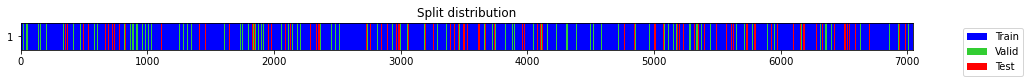

In [122]:
splits = get_splits(y, valid_size=0.1, test_size=0.1, stratify=True, random_state=23, shuffle=True)

In [123]:
splits

((#5641) [4765,1783,463,6781,5060,6218,6276,899,877,4545...],
 (#704) [6121,5155,4755,303,3249,5223,3579,6977,2917,6269...],
 (#704) [2689,1763,6787,3494,5385,3131,4377,5161,6563,956...])

In [124]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Training

In [125]:
nFoG = [element for element in y if element == 0]
print(len(nFoG))

FoG = [element for element in y if element == 1]
print(len(FoG))

5027
2022


In [126]:
def get_test_f1(X, y, splits, model):
  actual = [0 if target == 0 else 1 for target in y[splits[2]]]

  raw_preds, target, preds = model.get_X_preds(X[splits[2]])
  predicted = [0 if pred[0] == False else 1 for pred in preds]

  confusion_matrix = metrics.confusion_matrix(actual, predicted)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

  cm_display.plot()
  plt.show()

  tp = confusion_matrix[1,1]
  fp = confusion_matrix[0,1]
  fn = confusion_matrix[1,0]
  pre = tp/(tp+fp)
  re = tp/(tp+fn)
  f1 = 2*pre*re/(pre+re)
  return f1

# def objective(trial):

In [127]:
categories = []

## Optuna

In [178]:
def objective(trial):
    
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 512])
    pred_val = trial.suggest_int("pred_val", 1, 450, 49)
    num_epochs = trial.suggest_int("num_epochs", 15, 50)
    weight_decay = trial.suggest_float("weight_decay", 0.00001, 0.01, log=True)
    normalization = trial.suggest_categorical("normalization", [True, False])
    window_length = trial.suggest_int("window_length", 10, 1000)
    
    X, y = create_sliding_windows(df, window_length=250, horizon=500, pred_val=pred_val)
    scaler = StandardScaler()
    
    if normalization:
        X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    splits = get_splits(y, valid_size=0.1, test_size=0.1, stratify=True, random_state=23, shuffle=True)
    model = train(X, y, splits, learning_rate, LSTM_FCNPlus, bs=batch_size, wd=weight_decay)
    f1 = get_test_f1(X, y, splits, model)
    print(f1)
    return f1
    

[I 2022-12-05 00:15:52,086] A new study created in memory with name: no-name-fcfeb0ec-372d-402f-9d60-3270825e4cd4


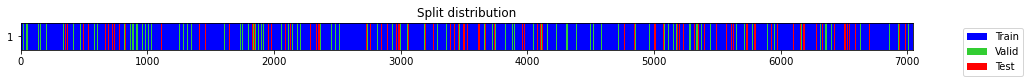

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.694274,0.678176,0.536551,0.555718,00:01
1,0.644607,0.624099,0.575785,0.573636,00:01
2,0.577975,0.554873,0.557991,0.573232,00:01
3,0.534044,0.515763,0.532633,0.557384,00:01
4,0.489515,0.487316,0.619658,0.612777,00:01
5,0.467916,0.459831,0.665367,0.648850,00:01
6,0.451152,0.440010,0.764548,0.751213,00:01
7,0.422127,0.414618,0.763148,0.745809,00:01
8,0.398251,0.393828,0.761899,0.742367,00:01
9,0.381898,0.381307,0.772968,0.755227,00:01


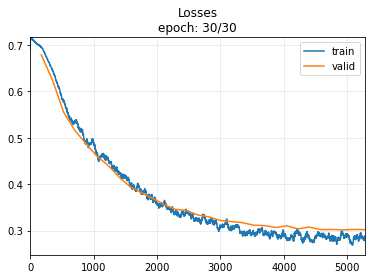

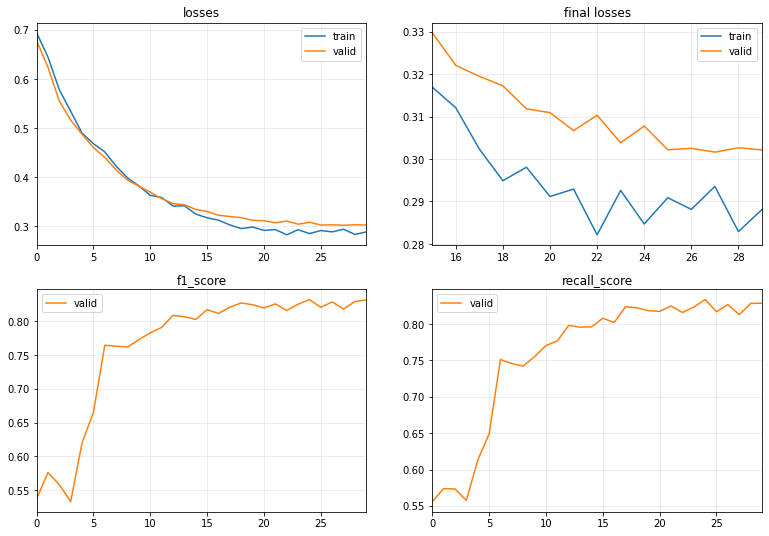

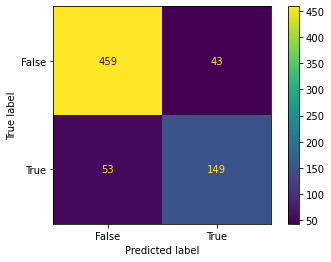

[I 2022-12-05 00:16:57,313] Trial 0 finished with value: 0.7563451776649746 and parameters: {'learning_rate': 3.816427503024796e-05, 'batch_size': 64, 'pred_val': 351, 'weight_decay': 0.0058226896713472875}. Best is trial 0 with value: 0.7563451776649746.


0.7563451776649746


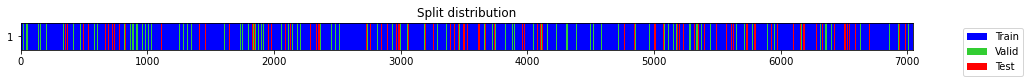

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.627067,0.585832,0.588773,0.588448,00:01
1,0.534925,0.512242,0.606020,0.602876,00:01
2,0.474636,0.457811,0.744350,0.728453,00:01
3,0.428405,0.405860,0.760592,0.745779,00:01
4,0.365200,0.372787,0.798289,0.795225,00:01
5,0.329309,0.353304,0.805305,0.802168,00:01
6,0.307778,0.328077,0.798157,0.787858,00:01
7,0.296111,0.308614,0.828426,0.828912,00:01
8,0.295132,0.290208,0.826437,0.826437,00:01
9,0.271249,0.296930,0.829248,0.842196,00:01


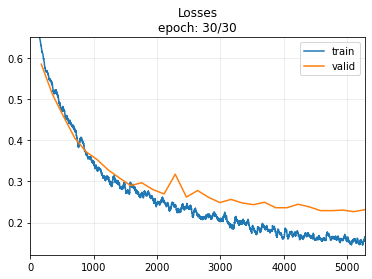

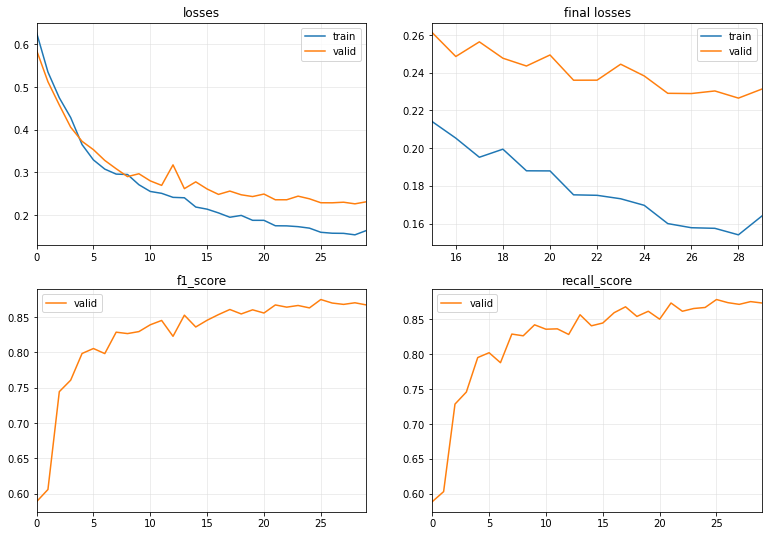

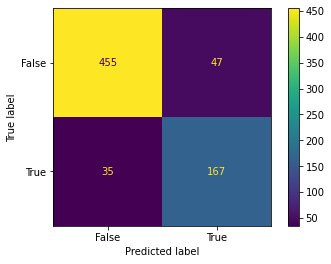

[I 2022-12-05 00:18:01,519] Trial 1 finished with value: 0.8028846153846153 and parameters: {'learning_rate': 0.00024061645506200858, 'batch_size': 64, 'pred_val': 351, 'weight_decay': 0.0019340840345715416}. Best is trial 1 with value: 0.8028846153846153.


0.8028846153846153


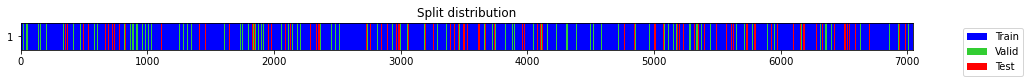

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.528831,0.493526,0.576870,0.584099,00:01
1,0.459154,0.423098,0.747102,0.727999,00:01
2,0.382451,0.364055,0.808813,0.805639,00:01
3,0.336555,0.337140,0.819158,0.835223,00:01
4,0.323771,0.316278,0.847934,0.866948,00:01
5,0.311730,0.330058,0.777988,0.757731,00:01
6,0.295269,0.285296,0.847726,0.857106,00:01
7,0.273275,0.302272,0.829248,0.842196,00:01
8,0.274167,0.344073,0.798667,0.791300,00:01
9,0.275401,0.293775,0.830030,0.817621,00:01


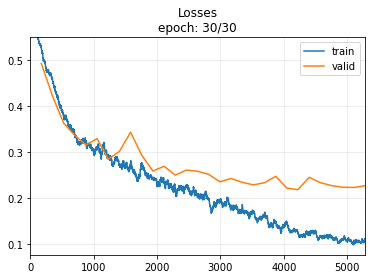

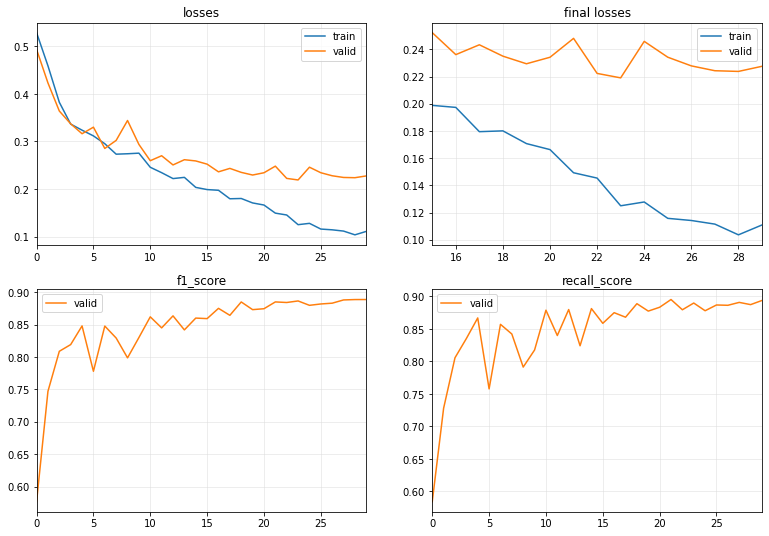

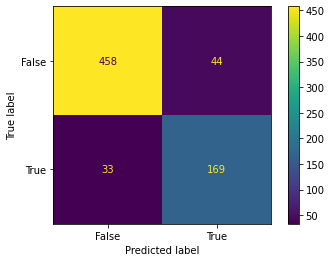

[I 2022-12-05 00:19:05,678] Trial 2 finished with value: 0.8144578313253011 and parameters: {'learning_rate': 0.0007827882422633956, 'batch_size': 128, 'pred_val': 1, 'weight_decay': 0.000545978648256781}. Best is trial 2 with value: 0.8144578313253011.


0.8144578313253011


In [176]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3)

In [ ]:
# Models to try

# LSTM_FCNPlus
# MLSTM_FCN

In [177]:
def train(X, y, splits, learning_rate, arch, bs=32, wd=None, num_epochs=30):
    batch_tfms = TSStandardize()
    model_name = "fcst_8feat_hzn_1ms_3sec_alldata_no-overlap"
    fcst = TSForecaster(X, y, splits=splits, loss_func=BCEWithLogitsLossFlat(), batch_tfms=batch_tfms, path='models', bs=bs, arch=arch, metrics=[ F1ScoreMulti(), RecallMulti()], cbs=ShowGraph(), num_workers=16, wd=wd)
    fcst.fit_one_cycle(num_epochs, learning_rate)
    fcst.export(f"{model_name}.pkl")
    return fcst

## Manual Experinment

In [172]:
X, y = create_sliding_windows(df, window_length=250, horizon=500, pred_val=1)


In [173]:
X.shape

(14100, 31, 250)

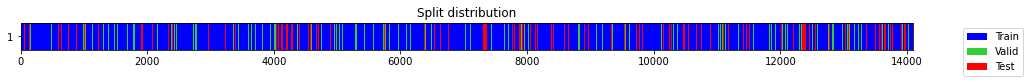

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.488875,0.468655,0.663706,0.647656,00:03
1,0.408228,0.378755,0.773794,0.765142,00:03
2,0.367967,0.324881,0.819438,0.816148,00:03
3,0.349723,0.309790,0.825231,0.822833,00:03
4,0.336676,0.333296,0.822430,0.834643,00:03
5,0.352029,0.320803,0.812426,0.809209,00:04
6,0.316348,0.340781,0.819110,0.846453,00:04
7,0.306407,0.279295,0.844924,0.843395,00:04
8,0.295168,0.279083,0.869095,0.884938,00:04
9,0.287116,0.276573,0.839581,0.849281,00:04


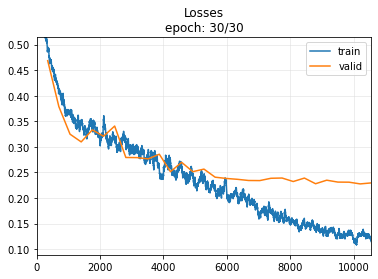

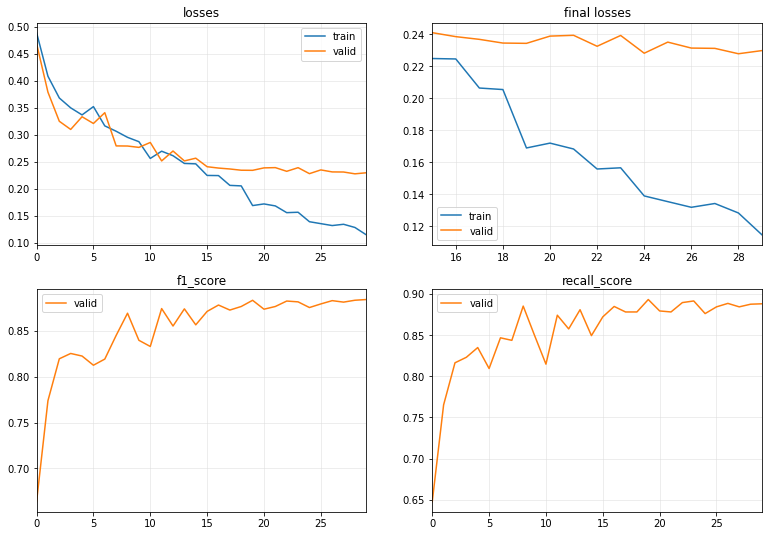

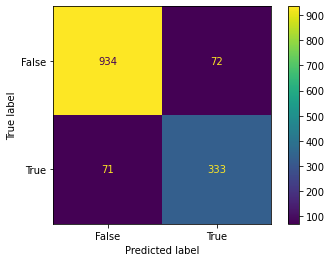

0.823238566131026


In [174]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
splits = get_splits(y, valid_size=0.1, test_size=0.1, stratify=True, random_state=23, shuffle=True)
model = train(X, y, splits, 1e-3, LSTM_FCNPlus, wd=0.001)
f1 = get_test_f1(X, y, splits, model)
print(f1)

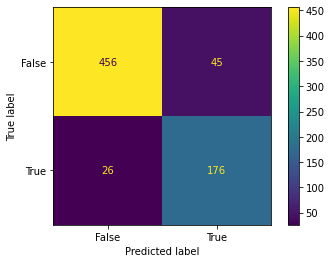

0.8321513002364066


In [66]:
# all below for horizon[250]

# LSTM_FCNPlus
# No scaling 0.83
# Normalization 0.82
# Normalization 0.797136


# MLSTM_FCN
# Normalization 0.814

#Ng data preparation
# MLSTM_FCN
# 0.8029 f1

# LSTM_FCNPlus
# 0.8048 f1 15 epoch
# no normalization 0.79512195
# no normalization 30 epochs 0.813 f1
# no normalization 30 epochs wd 0.001 0.819 f1
# no normalization 30 epochs wd 0.01 0.811 f1
# no normalization 30 epochs wd 0.01 batchsize 32 0.825 f1
# no normalization 30 epochs wd 0.01 batchsize 128 0.814 f1
# no normalization 30 epochs wd 0.01 batchsize 128 window_length=250 0.846153846 f1
# no normalization 30 epochs wd 0.01 batchsize 128 window_length=100 0.837983 f1



# MGRU_FCN
# no normalization 30 epochs wd 0.001 0.7883 f1

# TST
# 0.765550


# all below for horizon[100]
# no normalization 30 epochs wd 0.01 batchsize 128 window_length=250 0.83519 f1

# all below for horizon[50]
# no normalization 30 epochs wd 0.01 batchsize 128 window_length=250 0.8396572 f1

# all below for horizon[1]
# no normalization 30 epochs wd 0.01 batchsize 128 window_length=250 0.8396572 f1





In [108]:
# splits_test = get_splits(y, valid_size=0, stratify=True, random_state=23, shuffle=True)
actual = [0 if target == 0 else 1 for target in y[splits[2]]]

raw_preds, target, preds = fcst.get_X_preds(X[splits[2]])
predicted = [0 if pred[0] == False else 1 for pred in preds]

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

tp = confusion_matrix[1,1]
fp = confusion_matrix[0,1]
fn = confusion_matrix[1,0]
tn = confusion_matrix[0,0]
r = (tp+fn)/(fp+tn)
pre = tp/(tp+fp)
re = tp/(tp+fn)
f1 = 2*pre*re/(pre+re)

print("test f1", f1)
print("dummy f1", 2*r/(1+r))

RuntimeError: Given groups=1, weight of size [128, 30, 7], expected input[64, 31, 500] to have 30 channels, but got 31 channels instead